# Computing the S isotope fractionation factors for the oxidation of sulfide by Desulfurivibrio alkaliphilus from experimental data

In [1207]:
# For numerical calculations
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy import arange
from pylab import *
from scipy.integrate import odeint
import scipy.optimize 
from scipy.optimize import leastsq
from math import exp
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
import git

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

In [1208]:
# Import table with data
df_data =  pd.read_csv ('/Users/daniosro/git/MSO/d_alk/data/raw/EA/202202_EA.csv')

# Keep only rows with Peak Nr=3, since Peak Nr=1,2,4 and 5 
# correspond to the reference gas
#Select rows to drop
i1 = df_data[df_data['Peak_Nr'] == 1].index
i2 = df_data[df_data['Peak_Nr'] == 2].index
i4 = df_data[df_data['Peak_Nr'] == 4].index
i5 = df_data[df_data['Peak_Nr'] == 5].index
#Drop rows in place
df_data.drop(i1, inplace=True)
df_data.drop(i2, inplace=True)
df_data.drop(i4, inplace=True)
df_data.drop(i5, inplace=True)
df_data.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date
2,SID9,NaN,NaN,3,16.605,593,15.851,0.753,2813,-9.875,standard,NaN,20220212
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212
12,Control,0.0,1.0,3,7.861,274,7.502,0.358,1309,-3.448,control,sulfide,20220212
17,Control,33.5,1.0,3,11.433,415,10.911,0.521,1982,-3.924,control,sulfide,20220212
22,Control,54.5,1.0,3,11.239,409,10.727,0.512,1949,-4.246,control,sulfide,20220212


Then, let's load the data for the blanks:

In [1209]:
# Import table with the raw data for blanks
df_blanks = pd.read_csv('/Users/daniosro/git/MSO/d_alk/data/raw/EA/202202_blanks.csv')

# Remove rows with missing data
df_blanks.dropna(how='any', inplace=True)

# Keep only rows with Peak Nr=3
#Select rows to drop
i1 = df_blanks[df_blanks['Peak_Nr'] == 1].index
i2 = df_blanks[df_blanks['Peak_Nr'] == 2].index
i4 = df_blanks[df_blanks['Peak_Nr'] == 4].index
i5 = df_blanks[df_blanks['Peak_Nr'] == 5].index
#Drop rows in place
df_blanks.drop(i1, inplace=True)
df_blanks.drop(i2, inplace=True)
df_blanks.drop(i4, inplace=True)
df_blanks.drop(i5, inplace=True)
df_blanks.head()

,Identifier,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Date
2,Blank-1,3,0.448,17,0.428,0.021,80,0.029,20220212
7,Blank-2,3,0.518,18,0.494,0.024,86,1.703,20220212
12,Blank,3,0.601,21,0.573,0.028,98,0.328,20220212
17,Blank,3,4.985,165,4.757,0.229,792,1.619,20220212
22,Blank-2,3,1.518,56,1.449,0.069,265,-0.458,20220215


Finally, let's load the data for the linearity test at the beginning of the run:

In [1210]:
# Import file
df_lin =  pd.read_csv('/Users/daniosro/git/MSO/d_alk/data/raw/EA/202202_linearity.csv')
df_lin.head()

,Identifier,Peak_Nr,Ampl_64,Ampl_66,d34S,Date
0,linearity,1,510,2446,-0.153,20220212
1,linearity,2,1729,8294,0.000,20220212
2,linearity,3,2614,12544,0.044,20220212
3,linearity,4,3165,15187,0.068,20220212
4,linearity,5,4317,20718,0.143,20220212


Now, let's implement the corrections.

## Blank correction

In [1211]:
# Get the average area all for the blanks
blank_area_all_average = df_blanks["Area_All"].mean()

# Get the average d34S for the blanks
blank_d34s_average = df_blanks["d34S"].mean()

# Append a column to the data dataframe with the 
# correction of area by blank: substraction of the
# area of the measurement by the area of the blank

df_data['Correction_of_area_blank'] = \
    np.subtract(df_data['Area_All'], blank_area_all_average)

# Correction of d34S by blank: 
    
# Get the product of the d34S by the area of each measurement
num1 = np.multiply (df_data['d34S'], df_data['Area_All'])
# Get the product of the d34S by the area of the average of the blanks
num2 = blank_d34s_average * blank_area_all_average  
#Subtract the product of d34S by the product of the blanks
num = np.subtract (num1, num2)
#Divide by the area corrected by blank and
#append column to the data dataframe
df_data['Correction_of_d34S_blank'] = \
    np.divide (num, df_data['Correction_of_area_blank'])

df_data.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank
2,SID9,NaN,NaN,3,16.605,593,15.851,0.753,2813,-9.875,standard,NaN,20220212,13.7196,-11.939537
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212,10.2076,1.155539
12,Control,0.0,1.0,3,7.861,274,7.502,0.358,1309,-3.448,control,sulfide,20220212,4.9756,-5.413624
17,Control,33.5,1.0,3,11.433,415,10.911,0.521,1982,-3.924,control,sulfide,20220212,8.5476,-5.228882
22,Control,54.5,1.0,3,11.239,409,10.727,0.512,1949,-4.246,control,sulfide,20220212,8.3536,-5.692407


## Linearity correction

In [1212]:
# Create variables for linear regression
# x will be the amplitude of the peak of mass 64 = ^32S + ^16O + ^16O
# We divided by 1000 to convert volts ot milivolts
x = (df_lin['Ampl_64'].values/1000).reshape((-1,1))
# y will be the values of d34S
y = (df_lin['d34S'])

# Create model of linear regression
model = LinearRegression().fit(x,y)

#Determine R square, intercept and slope
r_sq = model.score(x,y)
intercept = model.intercept_
s = model.coef_
slope=s[0]

# Calculate an amplitude difference by centering around an arbitrary 
# value in the Ampl_64 column of the data dataframe  
num= np.subtract(df_data['Ampl_64'], 1100)
ampl_difference = np.divide (num, 1000)

# Calculate the amplitude correction factor
ampl_correction_factor = (slope * ampl_difference)+intercept

# Correct the d34S corrected by amplitude by
# subtracting the blank corrected data by the amplitude correction
# factor and append the column to the data dataframe
df_data['Correction_of_d34S_by_amplitude'] = \
    np.subtract(df_data['Correction_of_d34S_blank'], ampl_correction_factor)

df_data

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude
2,SID9,NaN,NaN,3,16.605,593,15.851,0.753,2813,-9.875,standard,NaN,20220212,13.7196,-11.939537,-11.426760
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212,10.2076,1.155539,1.689504
12,Control,0.0,1.0,3,7.861,274,7.502,0.358,1309,-3.448,control,sulfide,20220212,4.9756,-5.413624,-4.840500
17,Control,33.5,1.0,3,11.433,415,10.911,0.521,1982,-3.924,control,sulfide,20220212,8.5476,-5.228882,-4.682432
22,Control,54.5,1.0,3,11.239,409,10.727,0.512,1949,-4.246,control,sulfide,20220212,8.3536,-5.692407,-5.144822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,AGS_2,NaN,NaN,3,23.782,890,22.693,1.089,4266,0.587,standard,NaN,20220218,20.8966,0.676126,1.132719
787,SID9,NaN,NaN,3,69.097,2500,65.975,3.121,11816,-10.300,standard,NaN,20220218,66.2116,-10.746310,-10.594286
792,SID9,NaN,NaN,3,52.166,1868,49.806,2.361,8844,-10.290,standard,NaN,20220218,49.2806,-10.889061,-10.617479
797,SW,NaN,NaN,3,35.963,1322,34.291,1.672,6439,18.175,standard,NaN,20220218,33.0776,19.765528,20.140398


## Standard correction 

First, let's create a category column in the dataframe according to the size of the area of the peak of each sample and standard.

In [1213]:
# Correct each sample by standards with similar areas

#Create standard correction group empty list
Std_group = []
# Classify the area of the samples by category 
# Loop through dataframe rows
for row in df_data['Area_All']:
    if row <= 30:
        Std_group.append ('low')
    elif row >= 30.01:
        Std_group.append ('high') 
# Append to data dataframe 
df_data['Std_group'] = Std_group
df_data.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group
2,SID9,NaN,NaN,3,16.605,593,15.851,0.753,2813,-9.875,standard,NaN,20220212,13.7196,-11.939537,-11.426760,low
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212,10.2076,1.155539,1.689504,low
12,Control,0.0,1.0,3,7.861,274,7.502,0.358,1309,-3.448,control,sulfide,20220212,4.9756,-5.413624,-4.840500,low
17,Control,33.5,1.0,3,11.433,415,10.911,0.521,1982,-3.924,control,sulfide,20220212,8.5476,-5.228882,-4.682432,low
22,Control,54.5,1.0,3,11.239,409,10.727,0.512,1949,-4.246,control,sulfide,20220212,8.3536,-5.692407,-5.144822,low


In [1214]:
# Create df with only standard data
df_standards = df_data[(df_data.Type == 'standard')] 
#Sort values by ID and area
df_standards = df_standards.sort_values(['Identifier', 'Date', 'Area_All'])

df_standards.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212,10.2076,1.155539,1.689504,low
227,AGS_2,NaN,NaN,3,16.525,620,15.769,0.756,2972,0.901,standard,NaN,20220215,13.6396,1.103971,1.611641,low
147,AGS_2,NaN,NaN,3,24.094,894,22.992,1.102,4283,0.758,standard,NaN,20220215,21.2086,0.869079,1.324915,low
62,AGS_2,NaN,NaN,3,27.455,1027,26.200,1.255,4917,0.908,standard,NaN,20220215,24.5696,1.021500,1.452176,low
67,AGS_2,NaN,NaN,3,30.317,1154,28.931,1.386,5522,1.052,standard,NaN,20220215,27.4316,1.168805,1.575456,high


In [1215]:
# Calculate the slope and intercept for calculated vs. true value of the stds

# Append true value column to the standard table
# For AGS2
df_standards.loc[df_standards['Identifier'] \
                  == 'AGS_2', 'True_d34S'] = 1.89
# For SW
df_standards.loc[df_standards['Identifier'] \
                  == 'SW', 'True_d34S'] = 21

# For SID9
df_standards.loc[df_standards['Identifier'] \
                  == 'SID9', 'True_d34S'] = -9.55
                       
# Group by Std_group
df_stdgroup = df_standards.groupby (['Std_group'])

df_standards.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group,True_d34S
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212,10.2076,1.155539,1.689504,low,1.89
227,AGS_2,NaN,NaN,3,16.525,620,15.769,0.756,2972,0.901,standard,NaN,20220215,13.6396,1.103971,1.611641,low,1.89
147,AGS_2,NaN,NaN,3,24.094,894,22.992,1.102,4283,0.758,standard,NaN,20220215,21.2086,0.869079,1.324915,low,1.89
62,AGS_2,NaN,NaN,3,27.455,1027,26.200,1.255,4917,0.908,standard,NaN,20220215,24.5696,1.021500,1.452176,low,1.89
67,AGS_2,NaN,NaN,3,30.317,1154,28.931,1.386,5522,1.052,standard,NaN,20220215,27.4316,1.168805,1.575456,high,1.89


Below, we make a linear regression for the standards of each area group.

In [1216]:
# Get the slope and intercept for the standards of each group
# Define column names
names = ['Std_group', 'R squared', 'Intercept', 'Slope']

# Initialize empty dataframe to save fit results
df_linreg_stds = pd.DataFrame(columns=names)
                 
# Create variables for linear regression
#Loop through standard groups                       
for group, data in enumerate (df_stdgroup):
    #x will be the values of d34S of the stds corrected by blanks and linearity
    x_std = data[1].Correction_of_d34S_by_amplitude.values.reshape((-1,1))
    #y will be the true values of d34S of each standard
    y_std = data[1].True_d34S
    # Create model
    model = LinearRegression().fit(x_std,y_std)
    #Determine R square, intercept and slope
    r_sq_stds = model.score(x_std,y_std)
    intercept_stds = model.intercept_
    s1 = model.coef_
    slope_stds = s1[0]
    # Store parameters and group as list
    params = (data[1].Std_group.unique(), r_sq_stds, intercept_stds, slope_stds)
 
    # Convert list to pandas Series
    series = pd.Series(params, index=names)   
    # Append parameters to dataframe
    df_linreg_stds = df_linreg_stds.append(series, ignore_index=True)
#Round the values of the dataframe to two decimal places
df_linreg_stds = df_linreg_stds.round(2)     
df_linreg_stds 

,Std_group,R squared,Intercept,Slope
0,[high],1.0,0.77,1.04
1,[low],1.0,0.65,0.98


Finally, let's apply the standard correction to the samples based on their area:

In [1217]:
#Apply corrections by true value and area

# Initialize lists to save values
slopes = []
intercepts = []
Correction_of_d34S_by_true_value = []

#loop through rows in dataframe
for index, row in df_data.iterrows():
    # Extract standard group
    Std_group = row.Std_group
    # Extract slope and intercept
    slope = df_linreg_stds[df_linreg_stds.Std_group == Std_group].Slope.iloc[0]
    intercept = df_linreg_stds[df_linreg_stds.Std_group == Std_group].Intercept.iloc[0]
    slopes.append(slope)
    intercepts.append(intercept)
    # Compute corrected concentration
    Correction_of_d34S_by_true_value.append(intercept + slope * row.Correction_of_d34S_by_amplitude)
    
# Append values to dataframe
df_data['Correction_of_d34S_by_true_value'] = Correction_of_d34S_by_true_value

df_data.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group,Correction_of_d34S_by_true_value
2,SID9,NaN,NaN,3,16.605,593,15.851,0.753,2813,-9.875,standard,NaN,20220212,13.7196,-11.939537,-11.426760,low,-10.548225
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212,10.2076,1.155539,1.689504,low,2.305714
12,Control,0.0,1.0,3,7.861,274,7.502,0.358,1309,-3.448,control,sulfide,20220212,4.9756,-5.413624,-4.840500,low,-4.093690
17,Control,33.5,1.0,3,11.433,415,10.911,0.521,1982,-3.924,control,sulfide,20220212,8.5476,-5.228882,-4.682432,low,-3.938783
22,Control,54.5,1.0,3,11.239,409,10.727,0.512,1949,-4.246,control,sulfide,20220212,8.3536,-5.692407,-5.144822,low,-4.391926


Since all the corrections have been done, we will now export the corrected data, which must be combined with the quantification data to get the plots of sulfide degradation and change in the $\delta^{34}S$ of the remaining sulfide as a function of time or -ln of sulfide remaining.

In [1218]:
# Create dataframe that includes only data from the samples
df_samples = df_data[(df_data.Type == 'sample')]

# Export data table
df_samples.to_csv('/Users/daniosro/git/MSO/d_alk/data/processed/EA/202202_EA.csv')
df_samples.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group,Correction_of_d34S_by_true_value
57,high,151.0,4.0,3,47.345,1638,45.183,2.163,7833,-2.537,sample,sulfate,20220212,44.4596,-2.697855,-2.382764,high,-1.708074
82,high,0.0,1.0,3,74.359,2702,70.973,3.385,12879,-3.373,sample,sulfide,20220215,71.4736,-3.506808,-3.392997,high,-2.758717
87,high,33.5,1.0,3,79.200,2888,75.599,3.601,13748,-4.864,sample,sulfide,20220215,76.3146,-5.045694,-4.967069,high,-4.395751
92,high,54.5,1.0,3,81.612,3046,77.908,3.705,14477,-6.431,sample,sulfide,20220215,78.7266,-6.664559,-6.615823,high,-6.110456
97,high,71.0,1.0,3,73.359,2606,70.039,3.320,12346,-15.908,sample,sulfide,20220215,70.4736,-16.556927,-16.424955,high,-16.311954


### Analytical repeatability of measurements

Let's calculate the analytical repeatability of the EA-IRMS measurements. 

In [1219]:
# Update standard df
# Create a dataframe for only standards from the updated data dataframe
df_standards = df_data[(df_data.Type == 'standard')]
#Sort values
df_standards = df_standards.sort_values(['Identifier', 'Area_All'])

#Group standards by identifier and area
grouped_standards = df_standards.groupby(['Identifier', 'Std_group'])

# Determine the mean of each standard  and rename the series
mean_stds = grouped_standards['Correction_of_d34S_by_true_value'].mean()
mean_stds = mean_stds.rename("d34S_mean")

# Determine the standard deviation of each standard  and rename the series
std_dev_stds = grouped_standards['Correction_of_d34S_by_true_value'].std()
std_dev_stds = std_dev_stds.rename("d34S_stdev")

#Pass series to individual dataframes
df_mean_stds=mean_stds.to_frame()
df_std_dev_stds=std_dev_stds.to_frame()


In [1220]:
#merge the mean and standard deviation dataframes
df_anrep = pd.merge(df_mean_stds, df_std_dev_stds,  how='outer', on=['Identifier', 'Std_group'])

#Reset index of the dataframe
df_anrep = df_anrep.reset_index()

#Add column of true value of the standards
df_anrep.loc[df_anrep['Identifier'] \
                  == 'AGS_2', 'True_d34S'] = 1.89
df_anrep.loc[df_anrep['Identifier'] \
                  == 'SW', 'True_d34S'] = 21
df_anrep.loc[df_anrep['Identifier'] \
                  == 'SID9', 'True_d34S'] = -9.55

#Determine the accuracy by subtracting the true value from the average value of each standard
df_anrep ['Accuracy'] = abs(df_anrep ['True_d34S'] - df_anrep ['d34S_mean'])
df_anrep

,Identifier,Std_group,d34S_mean,d34S_stdev,True_d34S,Accuracy
0,AGS_2,high,2.313439,0.124458,1.89,0.423439
1,AGS_2,low,2.043705,0.183298,1.89,0.153705
2,SID9,high,-9.706269,0.547362,-9.55,0.156269
3,SID9,low,-9.717426,0.981630,-9.55,0.167426
4,SW,high,20.848687,1.075341,21.00,0.151313
5,SW,low,20.703794,1.303076,21.00,0.296206


## Import the quantification data and calculate the fraction of sulfide remaining

Let's begin by loading the sulfide quantification data (Cline assay):

In [1221]:
# Import table with data
df_cline =  pd.read_csv(f'{homedir}/d_alk/data/raw/cline_assay/202202_cline.csv') 
#See data
df_cline.head()

,absorbance,type,hyp_conc,treatment,well,replicate,time_h,stdcurve_group
0,0.982,standard,2.5,NaN,1,NaN,NaN,a
1,0.914,standard,2.5,NaN,2,NaN,NaN,a
2,0.896,standard,2.5,NaN,3,NaN,NaN,a
3,0.732,standard,1.7,NaN,1,NaN,NaN,a
4,0.601,standard,1.7,NaN,2,NaN,NaN,a


In [1222]:
#Filter by standard group
df_cline_a = df_cline[(df_cline.stdcurve_group == 'a')]
#Filter by blank only
df_blank_a = df_cline_a[(df_cline_a.hyp_conc == 0)]
#Get the average of the absorbance for the blanks
avg_blank_a = df_blank_a['absorbance'].mean()

#Filter by second standard group
df_cline_b = df_cline[(df_cline.stdcurve_group == 'b')]
#Filter by blank only
df_blank_b = df_cline_b[(df_cline_b.hyp_conc == 0)]
#Get the average of the absorbance for the blanks
avg_blank_b = df_blank_b['absorbance'].mean()

#Subtract average of the blank absorbance from all the absorbances
#Create empty list to append the corrected absorbances
abs_corr = []
#Loop through rows in the dataframe with all the data
for i, row in df_cline.iterrows():
    #Determine corrected absorbance for the first standard group
    if row.stdcurve_group == 'a':
        absorbance = row.absorbance - avg_blank_a
    #Determine corrected absorbance for the second standard group
    else:
        absorbance = row.absorbance - avg_blank_b
    #Append corrected absorbance to list
    abs_corr.append (absorbance)
        
# Create a column from the list
df_cline['abs_corr'] = abs_corr
df_cline.head()

,absorbance,type,hyp_conc,treatment,well,replicate,time_h,stdcurve_group,abs_corr
0,0.982,standard,2.5,NaN,1,NaN,NaN,a,0.935667
1,0.914,standard,2.5,NaN,2,NaN,NaN,a,0.867667
2,0.896,standard,2.5,NaN,3,NaN,NaN,a,0.849667
3,0.732,standard,1.7,NaN,1,NaN,NaN,a,0.685667
4,0.601,standard,1.7,NaN,2,NaN,NaN,a,0.554667


In [1223]:
#Make standard curve

#Filter by standard group
df_cline_a = df_cline[(df_cline.stdcurve_group == 'a')]
df_cline_b = df_cline[(df_cline.stdcurve_group == 'b')]

#Filter by standard only for the first standard group
df_standard_a = df_cline_a[(df_cline_a.type == 'standard')]
#Filter by standard only for the second standard group
df_standard_b = df_cline_b[(df_cline_b.type == 'standard')]

# Calculate linear regression for the first standard group
z_a = np.polyfit(df_standard_a.abs_corr, df_standard_a.hyp_conc, 1)
p_a = np.poly1d(z_a)
# Calculate linear regression for the second standard group
z_b = np.polyfit(df_standard_b.abs_corr, df_standard_b.hyp_conc, 1)
p_b = np.poly1d(z_b)

#Insert into a new column in the standard dataframe for the first standard group
df_standard_a.insert(4,'reg',p_a(df_standard_a['abs_corr']))
df_standard_a.head()

,absorbance,type,hyp_conc,treatment,reg,well,replicate,time_h,stdcurve_group,abs_corr
0,0.982,standard,2.5,NaN,2.575701,1,NaN,NaN,a,0.935667
1,0.914,standard,2.5,NaN,2.382933,2,NaN,NaN,a,0.867667
2,0.896,standard,2.5,NaN,2.331907,3,NaN,NaN,a,0.849667
3,0.732,standard,1.7,NaN,1.866998,1,NaN,NaN,a,0.685667
4,0.601,standard,1.7,NaN,1.495638,2,NaN,NaN,a,0.554667


In [1224]:
#Insert into a new column in the standard dataframe for the second standard group
df_standard_b.insert(4,'reg',p_b(df_standard_b['abs_corr']))
df_standard_b.head()

,absorbance,type,hyp_conc,treatment,reg,well,replicate,time_h,stdcurve_group,abs_corr
87,0.828,standard,2.5,NaN,2.262199,1,NaN,NaN,b,0.781667
88,0.865,standard,2.5,NaN,2.374943,2,NaN,NaN,b,0.818667
89,0.858,standard,2.5,NaN,2.353613,3,NaN,NaN,b,0.811667
90,0.631,standard,1.7,NaN,1.661912,1,NaN,NaN,b,0.584667
91,0.729,standard,1.7,NaN,1.960532,2,NaN,NaN,b,0.682667


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Concentration ($mM$)')

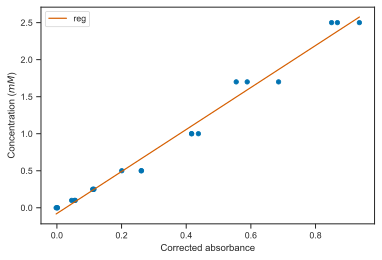

In [1225]:
#Plot the regression line for the standard from the first standard group
ax = df_standard_a.plot.scatter(x = 'abs_corr',y='hyp_conc')
df_standard_a.plot(x = 'abs_corr',y='reg',c='r',ax=ax)
ax.set_xlabel('Corrected absorbance')
ax.set_ylabel('Concentration ($mM$)')

In [1226]:
# Calculate the concentration of each sample

# Create empty list to append concentrations
conc = []
#Loop through full dataframe
for i, row in df_cline.iterrows():
    #Apply the linear regression for the first standard group samples based on the standard curve for that plate
    if row.stdcurve_group == 'a':
        real_conc = row.abs_corr *z_a[0] + z_a[1]
     #Apply the linear regression for the second standard group samples based on the standard curve for that plate
    else:
        real_conc = row.abs_corr *z_b[0] + z_b[1]
    #Append calculated concentrations to list
    conc.append (real_conc)
        
# Create a column from the list
df_cline['concentration'] = conc
df_cline.head()

,absorbance,type,hyp_conc,treatment,well,replicate,time_h,stdcurve_group,abs_corr,concentration
0,0.982,standard,2.5,NaN,1,NaN,NaN,a,0.935667,2.575701
1,0.914,standard,2.5,NaN,2,NaN,NaN,a,0.867667,2.382933
2,0.896,standard,2.5,NaN,3,NaN,NaN,a,0.849667,2.331907
3,0.732,standard,1.7,NaN,1,NaN,NaN,a,0.685667,1.866998
4,0.601,standard,1.7,NaN,2,NaN,NaN,a,0.554667,1.495638


In [1227]:
# Filter by sample only
df_samples_cline = df_cline[(df_cline.type == 'sample')]
#Multiply concentrations by 2 to correct for dilution factor
df_samples_cline['concentration'] = df_samples_cline['concentration']*2
df_samples_cline.head()

,absorbance,type,hyp_conc,treatment,well,replicate,time_h,stdcurve_group,abs_corr,concentration
21,1.921,sample,NaN,Control,1,1.0,0.0,a,1.874667,10.475173
22,1.848,sample,NaN,Control,2,1.0,0.0,a,1.801667,10.061291
23,1.922,sample,NaN,Control,3,1.0,0.0,a,1.875667,10.480842
24,1.906,sample,NaN,high,1,1.0,0.0,a,1.859667,10.390128
25,1.916,sample,NaN,high,2,1.0,0.0,a,1.869667,10.446825


In [1228]:
#Get average concentrations of the three wells for each replicate
df_samples_cline['avg_conc'] = df_samples_cline.groupby(['treatment','time_h','replicate'])['concentration'].transform(mean)
df_samples_cline.head()

,absorbance,type,hyp_conc,treatment,well,replicate,time_h,stdcurve_group,abs_corr,concentration,avg_conc
21,1.921,sample,NaN,Control,1,1.0,0.0,a,1.874667,10.475173,10.339102
22,1.848,sample,NaN,Control,2,1.0,0.0,a,1.801667,10.061291,10.339102
23,1.922,sample,NaN,Control,3,1.0,0.0,a,1.875667,10.480842,10.339102
24,1.906,sample,NaN,high,1,1.0,0.0,a,1.859667,10.390128,10.560217
25,1.916,sample,NaN,high,2,1.0,0.0,a,1.869667,10.446825,10.560217


We will calculate the fraction of reactant remaining for each replicate at each time point:

In [1229]:
#Create ID column with the combination of treatment, time and replicate
df_samples_cline['ID'] = df_samples_cline['treatment'] + '_' +\
df_samples_cline['time_h'].astype(int).map(str) + '_' + \
df_samples_cline['replicate'].map(str)

# Get the max values for average concentration for each treatment and replicate and 
# append it to a new column
df_samples_cline['max_conc'] = \
df_samples_cline.groupby(['treatment','replicate'])['avg_conc'].transform(max)

# Get the fraction of reactant remaining for each time point
df_samples_cline['f_R'] = abs(np.divide(df_samples_cline['avg_conc'], \
               df_samples_cline['max_conc']))

# Remove duplicates
df_samples_cline = df_samples_cline.drop_duplicates(subset ="ID")

df_samples_cline.head()

,absorbance,type,hyp_conc,treatment,well,replicate,time_h,stdcurve_group,abs_corr,concentration,avg_conc,ID,max_conc,f_R
21,1.921,sample,NaN,Control,1,1.0,0.0,a,1.874667,10.475173,10.339102,Control_0_1.0,10.437886,0.990536
24,1.906,sample,NaN,high,1,1.0,0.0,a,1.859667,10.390128,10.560217,high_0_1.0,10.560217,1.000000
27,1.849,sample,NaN,high,1,2.0,0.0,a,1.802667,10.066960,10.690618,high_0_2.0,10.690618,1.000000
30,1.915,sample,NaN,high,1,3.0,0.0,a,1.868667,10.441155,10.768103,high_0_3.0,10.768103,1.000000
33,1.736,sample,NaN,medium,1,1.0,0.0,a,1.689667,9.426293,9.490549,medium_0_1.0,9.490549,1.000000


In [1230]:
# Export data table
df_samples_cline.to_csv(f'{homedir}/d_alk/data/processed/cline_assay/202202_cline.csv') 

## Create master table

Now, let's create a table to compile the corrected values from EA-IRMS and quantification of sulfide by Cline assay. We will begin by loading the processed EA data and dropping the non-needed columns:

In [1231]:
# Import tables with the EA processed data
df_ea_1 = pd.read_csv(f'{homedir}/d_alk/data/processed/EA/202202_EA.csv')
#Filter by sulfide measurements only
df_ea_sulfide = df_ea_1[(df_ea_1.Measurement == 'sulfide')]

# Create empty master dataframe
df_master=pd.DataFrame()

# Fill master table
df_master['treatment'] = df_ea_sulfide['Identifier']
df_master['d34S_corrected'] = df_ea_sulfide['Correction_of_d34S_by_true_value']
df_master['replicate'] = df_ea_sulfide['Replicate']
df_master['time_h'] = (df_ea_sulfide['Time_h']).astype(int)

#Create new ID column with the combination of enzyme, time and date
df_master['ID'] = df_master['treatment'] + '_' +\
df_master['time_h'].map(str) + '_' + df_master['replicate'].map(str)

# Sort values
df_master = df_master.sort_values(['treatment', 'replicate', 'time_h'])
df_master.head()

,treatment,d34S_corrected,replicate,time_h,ID
1,high,-2.758717,1.0,0,high_0_1.0
2,high,-4.395751,1.0,33,high_33_1.0
3,high,-6.110456,1.0,54,high_54_1.0
4,high,-16.311954,1.0,71,high_71_1.0
5,high,-31.238942,1.0,83,high_83_1.0


Now, we will fuse this table with the quantification by Cline assay table:

In [1232]:
# Append f_r (fraction of sulfide remaining) column to the master table               
df_master = df_master.merge(df_samples_cline.filter(['ID', 'f_R']), how='left',
                 left_on='ID', right_on='ID') 

# Append sulfide concentration column to the master table  
df_master = df_master.merge(df_samples_cline.filter(['ID', 'avg_conc']), \
                            how='left', left_on='ID', right_on='ID')  

# Append -ln(f_r) column to the master table
df_master['minus_ln_f_R'] = abs(-np.log(df_master['f_R']))

df_master.head()

,treatment,d34S_corrected,replicate,time_h,ID,f_R,avg_conc,minus_ln_f_R
0,high,-2.758717,1.0,0,high_0_1.0,1.000000,10.560217,0.000000
1,high,-4.395751,1.0,33,high_33_1.0,0.707756,7.474055,0.345656
2,high,-6.110456,1.0,54,high_54_1.0,0.536355,5.664029,0.622958
3,high,-16.311954,1.0,71,high_71_1.0,0.257040,2.714395,1.358525
4,high,-31.238942,1.0,83,high_83_1.0,0.055440,0.585458,2.892455


To determine the fractionation factor $^{34}\varepsilon$, we will use a linearized form of the Rayleigh distillation equation (Mariotti et al., 1981; Scott et al., 2014):

$$
ln (^{34}\delta_{S^{-2}} +1) = ln (^{34}\delta_{S^{-2},0} +1) + {^{34}\varepsilon} \cdot ln f,
$$ 

where $^{34}\delta_{S^{-2}}$ is the delta value for 34/32 S for sulfide at any given point, $^{34}\delta_{S^{-2},0}$ is the delta value for 34/32 S for sulfide at t = 0, ${^{34}\varepsilon}$ is the fractionation factor of 34/32 S in the sulfide oxidation reaction and f is the fraction of sulfide remaining at the point where $^{34}\delta_{S^{-2}}$ is measured. We will append a column corresponding to $ln (^{34}\delta_{S^{-2}} +1)$ to the dataframe.

In [1233]:
#Calculate the ln (delta_sulfide+1) and append to dataframe
df_master['d34S_sulfide'] = 1000*np.log(df_master['d34S_corrected']/1000+1)

#Show dataframe
df_master.head()

,treatment,d34S_corrected,replicate,time_h,ID,f_R,avg_conc,minus_ln_f_R,d34S_sulfide
0,high,-2.758717,1.0,0,high_0_1.0,1.000000,10.560217,0.000000,-2.762529
1,high,-4.395751,1.0,33,high_33_1.0,0.707756,7.474055,0.345656,-4.405441
2,high,-6.110456,1.0,54,high_54_1.0,0.536355,5.664029,0.622958,-6.129201
3,high,-16.311954,1.0,71,high_71_1.0,0.257040,2.714395,1.358525,-16.446458
4,high,-31.238942,1.0,83,high_83_1.0,0.055440,0.585458,2.892455,-31.737284


Now, we can export the master table, with the corrected data from both Cline assay (quantification) and EA-IRMS for each enzyme.

In [1234]:
# Export master table with the data with all corrections

df_master.to_csv(f'{homedir}/d_alk/data/processed/EA_cline/202202_EA_cline.csv')

# Calculate $\epsilon$

In [1235]:
# Get the slope and intercept for each treatment

df_linreg = df_master.groupby(['treatment']).apply(
        lambda g: (((LinearRegression().fit((g.minus_ln_f_R.values).\
                                      reshape((-1,1)), g.d34S_sulfide.values)\
.coef_[0], LinearRegression().fit((g.minus_ln_f_R.values).reshape((-1,1)), \
                         g.d34S_sulfide.values).intercept_, LinearRegression().\
                     fit((g.minus_ln_f_R.values).reshape((-1,1)), g.d34S_sulfide.values).\
                     score((g.minus_ln_f_R.values).reshape((-1,1)), g.d34S_sulfide.values)\
                         )))).apply(pd.Series)\
.rename(columns={0:'slope', 1:'intercept', 2: 'R_squared'}).reset_index()

# Assign name as the index column
#df_100 =df_100.round(2)
df_linreg

,treatment,slope,intercept,R_squared
0,high,-11.591666,-0.862922,0.979464
1,lower,-18.581820,-3.120613,0.970080
2,medium,-14.739094,-2.436290,0.973766


# Plot of the isotope data

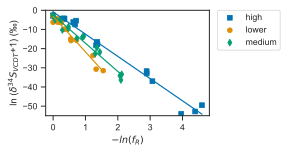

In [1236]:
# Group by treatment
df_group = df_master.groupby(['treatment'])

# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group))
# Define markers
markers = ['s', 'o', 'd','*']

# Define fig and axes
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Loop through replicates
for i, (group, data) in enumerate(df_group):
    #Calculate trendline  
    z = np.polyfit(data.minus_ln_f_R, data.d34S_sulfide, 1)
    p = np.poly1d(z)
 
    # Plot fit
    ax.plot(data.minus_ln_f_R, p(data.minus_ln_f_R), c=colors[i])
    
    # Plot experimental data
    ax.scatter(data.minus_ln_f_R, data.d34S_sulfide, color=colors[i], marker=markers[i],
              label = group)
    #ax.set_title('DddY')
    ax.set_xlabel('$-ln (f_R)$')
    ax.set_ylabel('ln ($\delta{}^{34}S_{VCDT}$+1) (‰)')
    ax.set_ylim(-55,0)

#Show legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#Save figure
fig.savefig(f'{homedir}/d_alk/figures/d_alk_fr_sulfide.pdf', bbox_inches='tight')